In [17]:
%matplotlib inline

import sqlite3
import json
import csv
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

from nltk.stem.porter import PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from wordcloud import WordCloud, STOPWORDS

## Reading data from JSON file

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
file_path = '/content/drive/My Drive/Merged.json'

df= pd.read_json(file_path,lines=True)
df

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A10000012B7CGYKOMPQ4L,000100039X,Adam,"[0, 0]",Spiritually and mentally inspiring! A book tha...,5,Wonderful!,1355616000,"12 16, 2012"
1,A2S166WSCFIFP5,000100039X,"adead_poet@hotmail.com ""adead_poet@hotmail.com""","[0, 2]",This is one my must have books. It is a master...,5,close to god,1071100800,"12 11, 2003"
2,A1BM81XB4QHOA3,000100039X,"Ahoro Blethends ""Seriously""","[0, 0]",This book provides a reflection that you can a...,5,Must Read for Life Afficianados,1390003200,"01 18, 2014"
3,A1MOSTXNIO5MPJ,000100039X,Alan Krug,"[0, 0]",I first read THE PROPHET in college back in th...,5,Timeless for every good and bad time in your l...,1317081600,"09 27, 2011"
4,A2XQ5LZHTD4AFT,000100039X,Alaturka,"[7, 9]",A timeless classic. It is a very demanding an...,5,A Modern Rumi,1033948800,"10 7, 2002"
...,...,...,...,...,...,...,...,...,...
320452,A1YMNTFLNDYQ1F,B00LORXVUE,eyeused2loveher,"[0, 0]",Works great just like my original one. I reall...,5,This works just perfect!,1405900800,"07 21, 2014"
320453,A15TX8B2L8B20S,B00LORXVUE,Jon Davidson,"[0, 0]",Great product. Great packaging. High quality a...,5,Great replacement cable. Apple certified,1405900800,"07 21, 2014"
320454,A3JI7QRZO1QG8X,B00LORXVUE,Joyce M. Davidson,"[0, 0]","This is a great cable, just as good as the mor...",5,Real quality,1405900800,"07 21, 2014"
320455,A1NHB2VC68YQNM,B00LORXVUE,Nurse Farrugia,"[0, 0]",I really like it becasue it works well with my...,5,I really like it becasue it works well with my...,1405814400,"07 20, 2014"


New Dataframe having only helpful attribute and productID. Droping the rest.

In [3]:
helpfulness = df[['helpful','asin']]
helpfulness

,helpful,asin
0,"[0, 0]",000100039X
1,"[0, 2]",000100039X
2,"[0, 0]",000100039X
3,"[0, 0]",000100039X
4,"[7, 9]",000100039X
...,...,...
320452,"[0, 0]",B00LORXVUE
320453,"[0, 0]",B00LORXVUE
320454,"[0, 0]",B00LORXVUE
320455,"[0, 0]",B00LORXVUE


In [4]:
df2 = pd.DataFrame(helpfulness)

In [5]:
df2[['helpful','total']] = pd.DataFrame(df2.helpful.values.tolist(), index=df2.index)
dfhelpful = df2[['asin', 'helpful','total']]

In [7]:
dfhelpful

,asin,helpful,total
0,000100039X,0,0
1,000100039X,0,2
2,000100039X,0,0
3,000100039X,0,0
4,000100039X,7,9
...,...,...,...
320452,B00LORXVUE,0,0
320453,B00LORXVUE,0,0
320454,B00LORXVUE,0,0
320455,B00LORXVUE,0,0


In [9]:
dfNew = df.drop('helpful',axis=1)

In [10]:
frames = [dfNew, dfhelpful]

In [11]:
result = dfNew.join(dfhelpful[['helpful','total']])
result

,reviewerID,asin,reviewerName,reviewText,overall,summary,unixReviewTime,reviewTime,helpful,total
0,A10000012B7CGYKOMPQ4L,000100039X,Adam,Spiritually and mentally inspiring! A book tha...,5,Wonderful!,1355616000,"12 16, 2012",0,0
1,A2S166WSCFIFP5,000100039X,"adead_poet@hotmail.com ""adead_poet@hotmail.com""",This is one my must have books. It is a master...,5,close to god,1071100800,"12 11, 2003",0,2
2,A1BM81XB4QHOA3,000100039X,"Ahoro Blethends ""Seriously""",This book provides a reflection that you can a...,5,Must Read for Life Afficianados,1390003200,"01 18, 2014",0,0
3,A1MOSTXNIO5MPJ,000100039X,Alan Krug,I first read THE PROPHET in college back in th...,5,Timeless for every good and bad time in your l...,1317081600,"09 27, 2011",0,0
4,A2XQ5LZHTD4AFT,000100039X,Alaturka,A timeless classic. It is a very demanding an...,5,A Modern Rumi,1033948800,"10 7, 2002",7,9
...,...,...,...,...,...,...,...,...,...,...
320452,A1YMNTFLNDYQ1F,B00LORXVUE,eyeused2loveher,Works great just like my original one. I reall...,5,This works just perfect!,1405900800,"07 21, 2014",0,0
320453,A15TX8B2L8B20S,B00LORXVUE,Jon Davidson,Great product. Great packaging. High quality a...,5,Great replacement cable. Apple certified,1405900800,"07 21, 2014",0,0
320454,A3JI7QRZO1QG8X,B00LORXVUE,Joyce M. Davidson,"This is a great cable, just as good as the mor...",5,Real quality,1405900800,"07 21, 2014",0,0
320455,A1NHB2VC68YQNM,B00LORXVUE,Nurse Farrugia,I really like it becasue it works well with my...,5,I really like it becasue it works well with my...,1405814400,"07 20, 2014",0,0


In [19]:
result.to_csv('reviews.csv', sep=',', header=False,index=False)

In [20]:
result

,reviewerID,asin,reviewerName,reviewText,overall,summary,unixReviewTime,reviewTime,helpful,total
0,A10000012B7CGYKOMPQ4L,000100039X,Adam,Spiritually and mentally inspiring! A book tha...,5,Wonderful!,1355616000,"12 16, 2012",0,0
1,A2S166WSCFIFP5,000100039X,"adead_poet@hotmail.com ""adead_poet@hotmail.com""",This is one my must have books. It is a master...,5,close to god,1071100800,"12 11, 2003",0,2
2,A1BM81XB4QHOA3,000100039X,"Ahoro Blethends ""Seriously""",This book provides a reflection that you can a...,5,Must Read for Life Afficianados,1390003200,"01 18, 2014",0,0
3,A1MOSTXNIO5MPJ,000100039X,Alan Krug,I first read THE PROPHET in college back in th...,5,Timeless for every good and bad time in your l...,1317081600,"09 27, 2011",0,0
4,A2XQ5LZHTD4AFT,000100039X,Alaturka,A timeless classic. It is a very demanding an...,5,A Modern Rumi,1033948800,"10 7, 2002",7,9
...,...,...,...,...,...,...,...,...,...,...
320452,A1YMNTFLNDYQ1F,B00LORXVUE,eyeused2loveher,Works great just like my original one. I reall...,5,This works just perfect!,1405900800,"07 21, 2014",0,0
320453,A15TX8B2L8B20S,B00LORXVUE,Jon Davidson,Great product. Great packaging. High quality a...,5,Great replacement cable. Apple certified,1405900800,"07 21, 2014",0,0
320454,A3JI7QRZO1QG8X,B00LORXVUE,Joyce M. Davidson,"This is a great cable, just as good as the mor...",5,Real quality,1405900800,"07 21, 2014",0,0
320455,A1NHB2VC68YQNM,B00LORXVUE,Nurse Farrugia,I really like it becasue it works well with my...,5,I really like it becasue it works well with my...,1405814400,"07 20, 2014",0,0


# **Loading CSV to SQLite**
Fetch the score and recommendation summary using SQL queries


In [27]:
result.columns

Index(['reviewerID', 'asin', 'reviewerName', 'reviewText', 'overall',
       'summary', 'unixReviewTime', 'reviewTime', 'helpful', 'total'],
      dtype='object')

In [32]:
class csvrd(object):
    def csvFile(self):

        self.readFile('reviews.csv')

    def readFile(self, filename):
        conn = sqlite3.connect('amazonReviews.db')
        cur = conn.cursor()
        cur.execute("""CREATE TABLE IF NOT EXISTS amazonReviews(reviewerID varchar, asin INT, reviewerName varchar, reviewText varchar, overall INT, summary varchar, unixReviewTime INTEGER, reviewTime INTEGER, helpful INT, total INT)""")
        filename.encode('utf-8')
        print ("Amazon Reviews table executed")
        with open(filename) as f:
            reader = csv.reader(f)
            for field in reader:
                cur.execute("INSERT INTO amazonReviews VALUES (?,?,?,?,?,?,?,?,?,?);", field)

        print ("CSV Loaded into SQLite")
        conn.commit()
        conn.close()

c = csvrd().csvFile()

Amazon Reviews table executed
CSV Loaded into SQLite


## Reading the data from SQLite

In [33]:
con = sqlite3.connect('amazonReviews.db')

pd.read_sql_query("SELECT * FROM amazonReviews LIMIT 5", con)

,reviewerID,asin,reviewerName,reviewText,overall,summary,unixReviewTime,reviewTime,helpful,total
0,A10000012B7CGYKOMPQ4L,000100039X,Adam,Spiritually and mentally inspiring! A book tha...,5,Wonderful!,1355616000,"12 16, 2012",0,0
1,A2S166WSCFIFP5,000100039X,"adead_poet@hotmail.com ""adead_poet@hotmail.com""",This is one my must have books. It is a master...,5,close to god,1071100800,"12 11, 2003",0,2
2,A1BM81XB4QHOA3,000100039X,"Ahoro Blethends ""Seriously""",This book provides a reflection that you can a...,5,Must Read for Life Afficianados,1390003200,"01 18, 2014",0,0
3,A1MOSTXNIO5MPJ,000100039X,Alan Krug,I first read THE PROPHET in college back in th...,5,Timeless for every good and bad time in your l...,1317081600,"09 27, 2011",0,0
4,A2XQ5LZHTD4AFT,000100039X,Alaturka,A timeless classic. It is a very demanding an...,5,A Modern Rumi,1033948800,"10 7, 2002",7,9


We are ignoring the reviews having overall score equal to 3. If the overall score is above 3, then the label for it will be set to Positive else it will be set to Negative.



In [34]:
reviews = pd.read_sql_query("""
SELECT
  overall,
  summary,
  helpful,
  total
FROM amazonReviews
WHERE overall != 3""", con)

In [35]:
#display data
reviews.head(5)

,overall,summary,helpful,total
0,5,Wonderful!,0,0
1,5,close to god,0,2
2,5,Must Read for Life Afficianados,0,0
3,5,Timeless for every good and bad time in your l...,0,0
4,5,A Modern Rumi,7,9


from matplotlib import pyplot as plt
_df_10['helpful'].plot(kind='hist', bins=20, title='helpful')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_11['total'].plot(kind='hist', bins=20, title='total')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_12.groupby('summary').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_13.plot(kind='scatter', x='helpful', y='total', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['overall']
  ys = series['total']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_14.sort_values('overall', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('summary')):
  _plot_series(series, series_name, i)
  fig.legend(title='summary', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('overall')
_ = plt.ylabel('total')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['overall']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'overall'}, axis=1)
              .sort_values('overall', ascending=True))
  xs = counted['overall']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_15.sort_values('overall', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('summary')):
  _plot_series(series, series_name, i)
  fig.legend(title='summary', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('overall')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['helpful']
  ys = series['total']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_16.sort_values('helpful', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('summary')):
  _plot_series(series, series_name, i)
  fig.legend(title='summary', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('helpful')
_ = plt.ylabel('total')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['helpful']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'helpful'}, axis=1)
              .sort_values('helpful', ascending=True))
  xs = counted['helpful']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_17.sort_values('helpful', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('summary')):
  _plot_series(series, series_name, i)
  fig.legend(title='summary', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('helpful')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_18['helpful'].plot(kind='line', figsize=(8, 4), title='helpful')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_19['total'].plot(kind='line', figsize=(8, 4), title='total')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_20['summary'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_20, x='helpful', y='summary', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_21['summary'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_21, x='total', y='summary', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

Sentiment column depicts the numeric score of being positive or negative. usefulScore column depicts the boolean value of total number of votes.

In [36]:
reviews["sentiment"] = reviews["overall"].apply(lambda score: "positive" if score > 3 else "negative")
reviews["usefulScore"] = (reviews["helpful"]/reviews["total"]).apply(lambda n: "useful" if n > 0.8 else "useless")

reviews.head(5)

,overall,summary,helpful,total,sentiment,usefulScore
0,5,Wonderful!,0,0,positive,useless
1,5,close to god,0,2,positive,useless
2,5,Must Read for Life Afficianados,0,0,positive,useless
3,5,Timeless for every good and bad time in your l...,0,0,positive,useless
4,5,A Modern Rumi,7,9,positive,useless


Rows having overall score equal to 5

In [37]:
reviews[reviews.overall == 5].head(5)

,overall,summary,helpful,total,sentiment,usefulScore
0,5,Wonderful!,0,0,positive,useless
1,5,close to god,0,2,positive,useless
2,5,Must Read for Life Afficianados,0,0,positive,useless
3,5,Timeless for every good and bad time in your l...,0,0,positive,useless
4,5,A Modern Rumi,7,9,positive,useless


In [38]:
#Rows having overall score equal to 1
reviews[reviews.overall == 1].head(5)

,overall,summary,helpful,total,sentiment,usefulScore
77,1,"Pasty, pasty! Too much!",2,9,negative,useless
117,1,adequate,0,56,negative,useless
140,1,"Read your Bible, not this book!",0,27,negative,useless
142,1,"Pompous, Pretentious, Platitudes",1,7,negative,useless
153,1,Deceptively pseudo-scriptural,53,130,negative,useless


## Feature extraction from reviewsText
Assign new dimension to each word and give the word counts.

In [39]:
regEx = re.compile('[^a-z]+')
def cleanReviews(reviewText):
    reviewText = reviewText.lower()
    reviewText = regEx.sub(' ', reviewText).strip()
    return reviewText

reviews["summaryClean"] = reviews["summary"].apply(cleanReviews)

train, test = train_test_split(reviews, test_size=0.2)
print("%d items in training data, %d in test data" % (len(train), len(test)))

455931 items in training data, 113983 in test data


## Using TfidfTransformer().fit_transofrm
To fit the train and test data.

In [40]:
countVector = CountVectorizer(min_df = 1, ngram_range = (1, 4))
X_train_counts = countVector.fit_transform(train["summaryClean"])

#applying tfidf to term frequency
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

X_new_counts = countVector.transform(test["summaryClean"])
X_test_tfidf = tfidf_transformer.transform(X_new_counts)

y_train = train["sentiment"]
y_test = test["sentiment"]

prediction = dict()

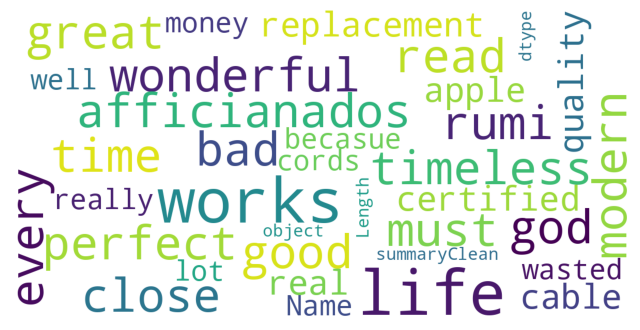

In [41]:
stopwords = set(STOPWORDS)

#mpl.rcParams['figure.figsize']=(8.0,6.0)    #(6.0,4.0)
mpl.rcParams['font.size']=12                #10
mpl.rcParams['savefig.dpi']=100             #72
mpl.rcParams['figure.subplot.bottom']=.1


def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40,
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(8, 8))
    plt.axis('off')
    if title:
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(reviews["summaryClean"])

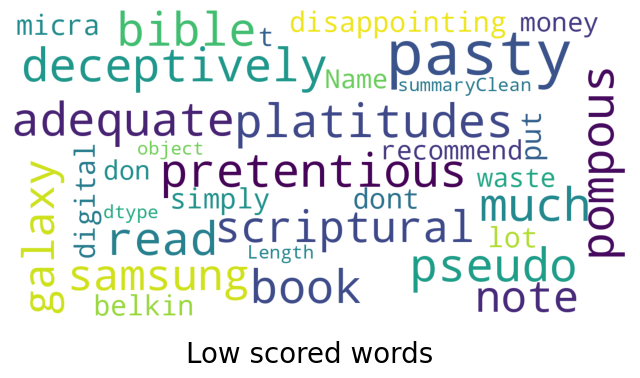

In [42]:
show_wordcloud(reviews[reviews.overall == 1]["summaryClean"], title = "Low scored words")

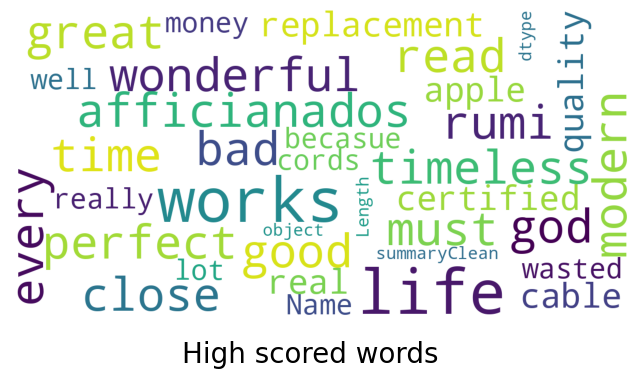

In [43]:
show_wordcloud(reviews[reviews.overall == 5]["summaryClean"], title = "High scored words")

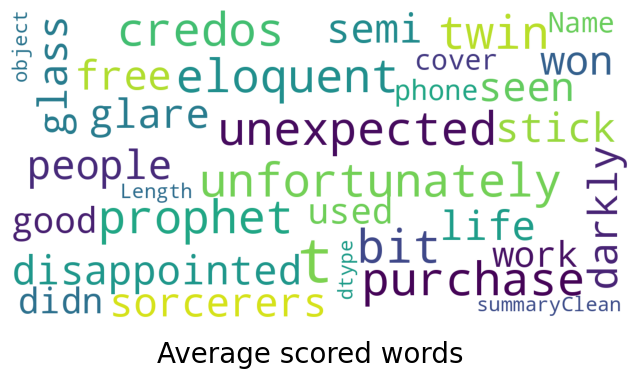

In [44]:
show_wordcloud(reviews[reviews.overall == 2]["summaryClean"], title = "Average scored words")

## Multinomial Naïve Bayes learning method

In [45]:
model = MultinomialNB().fit(X_train_tfidf, y_train)
prediction['Multinomial'] = model.predict(X_test_tfidf)

## Bernoulli Naïve Bayes learning method

In [46]:
model = BernoulliNB().fit(X_train_tfidf, y_train)
prediction['Bernoulli'] = model.predict(X_test_tfidf)

## Logistic regression learning method

In [47]:
logreg = LogisticRegression(C=1e5)
logreg_result = logreg.fit(X_train_tfidf, y_train)
prediction['Logistic'] = logreg.predict(X_test_tfidf)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Results

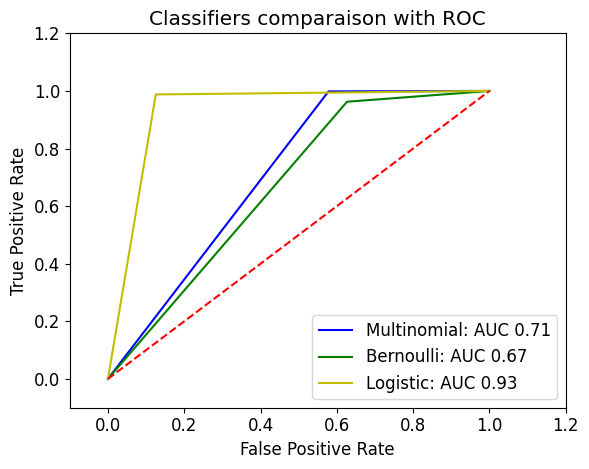

In [48]:
def formatt(x):
    if x == 'negative':
        return 0
    return 1
vfunc = np.vectorize(formatt)

cmp = 0
colors = ['b', 'g', 'y', 'm', 'k']
for model, predicted in prediction.items():
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test.map(formatt), vfunc(predicted))
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.plot(false_positive_rate, true_positive_rate, colors[cmp], label='%s: AUC %0.2f'% (model,roc_auc))
    cmp += 1

plt.title('Classifiers comparaison with ROC')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Visualize the accuracy, recall and f1-score for Logistic Regression

In [49]:
print(metrics.classification_report(y_test, prediction['Logistic'], target_names = ["positive", "negative"]))

              precision    recall  f1-score   support

    positive       0.91      0.87      0.89     14862
    negative       0.98      0.99      0.98     99121

    accuracy                           0.97    113983
   macro avg       0.95      0.93      0.94    113983
weighted avg       0.97      0.97      0.97    113983



In [50]:
accuracy_score(y_test, prediction['Logistic'])

0.972987199845591

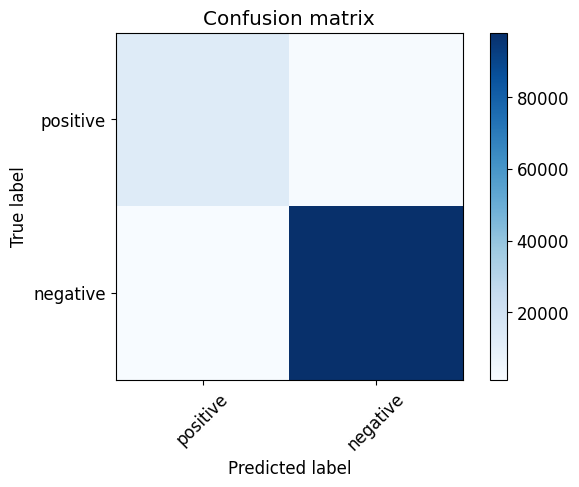

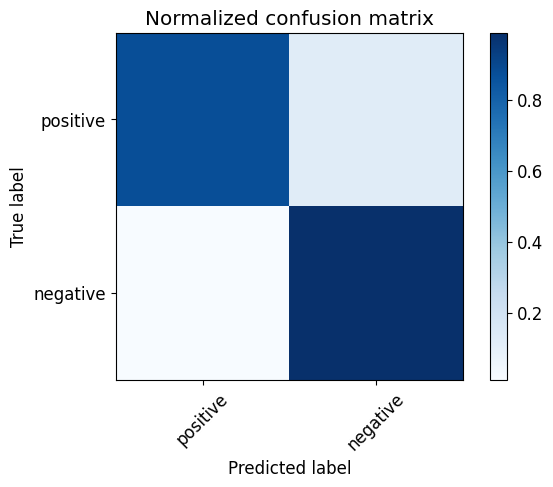

In [51]:
def plot_confusion_matrix(matrix, title='Confusion matrix', cmap=plt.cm.Blues, labels=["positive", "negative"]):
    plt.imshow(matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
matrix = confusion_matrix(y_test, prediction['Logistic'])
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(matrix)

matrix_normalized = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(matrix_normalized, title='Normalized confusion matrix')
plt.show()

## Visualize the accuracy, recall and f1-score for Naive Bayes Berrnoulli

In [52]:
print(metrics.classification_report(y_test, prediction['Bernoulli'], target_names = ["positive", "negative"]))

              precision    recall  f1-score   support

    positive       0.60      0.37      0.46     14862
    negative       0.91      0.96      0.94     99121

    accuracy                           0.89    113983
   macro avg       0.75      0.67      0.70    113983
weighted avg       0.87      0.89      0.87    113983



In [53]:
accuracy_score(y_test, prediction['Bernoulli'])

0.8856408411780704

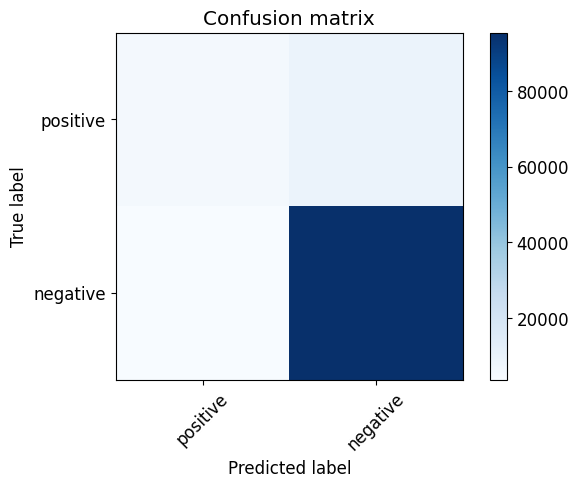

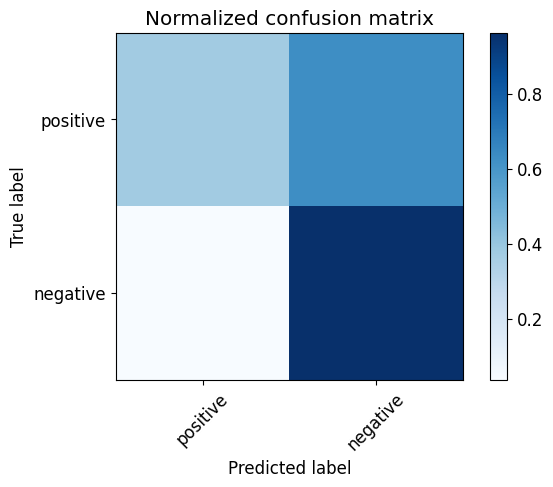

In [54]:
def plot_confusion_matrix(matrix, title='Confusion matrix', cmap=plt.cm.Blues, labels=["positive", "negative"]):
    plt.imshow(matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
matrix = confusion_matrix(y_test, prediction['Bernoulli'])
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(matrix)

matrix_normalized = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(matrix_normalized, title='Normalized confusion matrix')
plt.show()

## Visualize the accuracy, recall and f1-score for Naive Bayes Multinomial

In [55]:
print(metrics.classification_report(y_test, prediction['Multinomial'], target_names = ["positive", "negative"]))

              precision    recall  f1-score   support

    positive       0.97      0.42      0.59     14862
    negative       0.92      1.00      0.96     99121

    accuracy                           0.92    113983
   macro avg       0.95      0.71      0.77    113983
weighted avg       0.93      0.92      0.91    113983



In [56]:
accuracy_score(y_test, prediction['Multinomial'])

0.9231815270698263

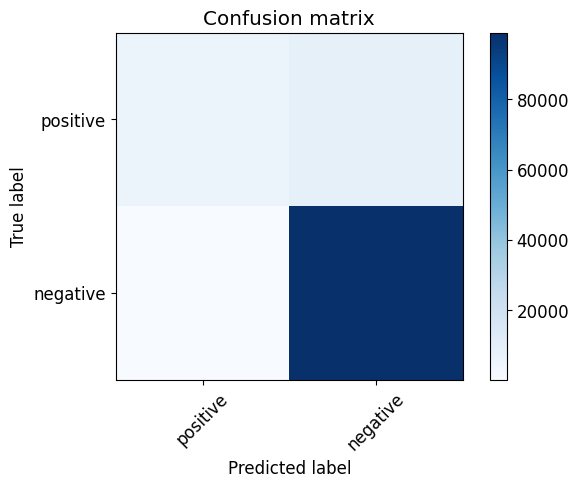

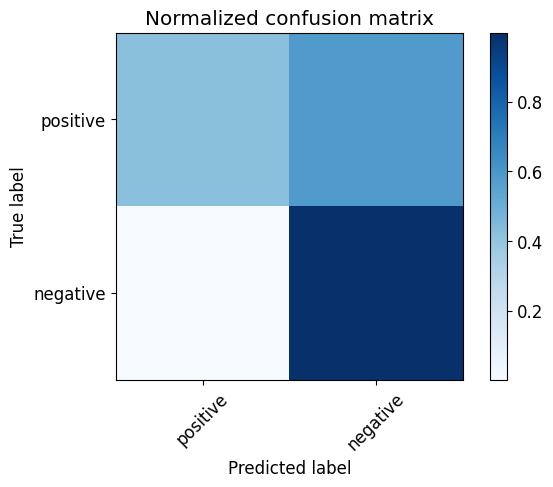

In [57]:
def plot_confusion_matrix(matrix, title='Confusion matrix', cmap=plt.cm.Blues, labels=["positive", "negative"]):
    plt.imshow(matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
matrix = confusion_matrix(y_test, prediction['Multinomial'])
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(matrix)

matrix_normalized = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(matrix_normalized, title='Normalized confusion matrix')
plt.show()

## Displaying words depicting the best and worst features
**Using Logistic Model since it gave the best results.**



In [60]:
features = countVector.get_feature_names_out()
feature_coefs = pd.DataFrame(
    data = list(zip(features, logreg_result.coef_[0])),
    columns = ['feature', 'coefficient'])

feature_coefs.sort_values(by='coefficient')

,feature,coefficient
486472,junk,-59.694831
234757,disappointing,-52.118392
686812,poorly,-50.975559
284670,fake,-49.313644
602041,not good,-47.993140
...,...,...
286412,fantastic,49.482939
599146,not bad,55.353958
606796,not too bad,55.638273
361585,good not,75.852984


## Testing the sentiments of few reviews

In [61]:
def testSentiments(model, testData):
    testCounts = countVector.transform([testData])
    testTfidf = tfidf_transformer.transform(testCounts)
    result = model.predict(testTfidf)[0]
    probability = model.predict_proba(testTfidf)[0]
    print("Sample estimated as %s: negative prob %f, positive prob %f" % (result.upper(), probability[0], probability[1]))

testSentiments(logreg, "Heavenly Highway Hymns")
testSentiments(logreg, "Very oily and creamy. Not at all what I expected... ordered this to try to highlight and contour and it just looked awful!!! Plus, took FOREVER to arrive.")
testSentiments(logreg, "Nasty smelling shampoo!.")

Sample estimated as POSITIVE: negative prob 0.001077, positive prob 0.998923
Sample estimated as NEGATIVE: negative prob 0.999871, positive prob 0.000129
Sample estimated as NEGATIVE: negative prob 0.989624, positive prob 0.010376


Rights: Vindhya V